# Individual Project for ECE 143

### Project Description

This is an analysis of Ad-Hoc Communications Network.

##### Requirement:
* All rectangular sections have integer-based corners. 
* All rectangular sections must be contained in the overall rectangular footprint. 
* The height and width of each rectangular section is sampled from a uniform distribution.
* Positions of the windows are also determined by uniform random distribution. 
* All footprints must be rectangles (not general polygons). 
* When a new tower comes online, if its coverage rectangle intersects the pre-existing composite footprint, then that new tower’s coverage is trimmed such that its maximum remaining coverage area is retained.



### Solutions:

The package that will be used in this project:

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Build the class of Rectangle and Map which represents the entire map/region to be covered by the rectangles.

In [65]:
class Rectangle():
    '''
    Each rectangle is characterized by 4 parameters
    xmin: the smallest x_coordinate
    xmax: the largest x_coordinate
    ymin: the smallest y_coordinate
    ymax: the largest y_coordinate
    
    Example: xmin=0, xmax=5, ymin=0, ymax=3 is a rectangle with vertices
             (0, 0), (5, 0), (0, 3), (5, 3)
    '''
    def __init__(self, position=[0,0,0,0]):
        # the initializer takes a list of 4 parameters as input
        # the list is [xmin, xmax, ymin, ymax]
        self.xmin, self.xmax, self.ymin, self.ymax = position
    def get_position(self):
        # this method returns the position parameters of the rectangle in a list
        return [self.xmin, self.xmax, self.ymin, self.ymax]
    def set_position(self, position):
        # this method modifies the position parameter of the rectangle
        self.xmin, self.xmax, self.ymin, self.ymax = position

In [66]:
class Map():
    '''
    This class represents the entire map/region to be covered by the rectangles.
    '''
    def __init__(self, shape=(0,0)):
        # The initialzer takes the shape of the map.
        # The shape is a tuple of two integers.
        # Shape (A, B) means the map has A rows and B columns of squares.
        self.shape = shape
        # isCovered stores whether squares on the map are covered.
        # isCovered[i, j] = 1 if the cell at i-th row and j-th column is already covered.
        #                 = 0 otherwise
        self.isCovered = np.zeros(shape) 
        # rectangles_on_map is a list storing the rectangles added onto the map
        self.rectangles_on_map = []
        # n is the total number of cells
        self.n = shape[0]*shape[1]
        
    def return_map(self):
        '''
        This method gets the status of whether cells are covered.
        '''
        return self.isCovered
    
    def rect_on_map_list(self):
        '''
        This method gets the list of rectangles on the map.
        '''
        return self.rectangles_on_map
    
    def cover(self, rect):
        '''
        This method update the status of cells covered by rect.
        '''
        xmin, xmax, ymin, ymax = rect.get_position()
        self.isCovered[xmin:xmax+1, ymin:ymax+1] = np.ones((xmax-xmin+1, ymax-ymin+1))
    
    def has_conflict(self, rect):
        '''
        This method is a rectangle has conflict with existing rectangles on the map.
        '''
        xmin, xmax, ymin, ymax = rect.get_position()
        isCovered = self.return_map()
        # get the isCovered status of cells in the rectangle
        isCovered_region = isCovered[xmin:xmax+1, ymin:ymax+1]
        # if any of them has been covered, return a conflict.
        if np.sum(np.sum(isCovered_region)) > 0:
            return True
        else:
            return False
    
    def add_rectangle(self, rect):
        '''
        This method adds a rectangle rect to the map.
        If rect has any conflict with existing rectangles on the map, 
        we find the largest sub-rectangle in rect with no conflict, and add it to the map.
        '''
        xmin, xmax, ymin, ymax = rect.get_position()
        # possible_size stores whether it's possible to find sub-rectangles of particular size.
        # possible_size[i, j] = 1 if it's possible to find a rect of height i+1 and width j+1
        # that has no conflict with existing ones on the map
        possible_size = np.ones((xmax-xmin+1, ymax-ymin+1))
        best_size = 0  # size the largest sub-rectangle.
        best_rect = None
        # check there exists a rectangle of height h+1 and width w+1 that can be added to the map
        for h in range(xmax-xmin+1):
            for w in range(ymax-ymin+1):
                size = (h+1)*(w+1) 
                if (size <= best_size) or (possible_size[h, w]==0):
                    # if the size of the rect we are checking if smaller than something we already have,
                    # don't bother
                    continue
                else:
                    # find if there exists a legit rectangle of height h+1 and width w+1
                    possible_rect, isPossible = self.find_legit_rect(rect, h, w)
                    if isPossible:
                        best_rect = possible_rect
                        best_size = size
                    else:
                        # if we cannot one with height h+1 and width w+1, 
                        # then we cannot find one with height >= h+1 and width >= w+1
                        possible_size[h:, w:] = 0
                        #possible_size[:, w+1:] = 0
        if best_rect is not None:
            # cover the map with the best sub-rectangle we have found.
            self.cover(best_rect)
            self.rectangles_on_map.append(best_rect)
        
    def find_legit_rect(self, rect, h, w):
        '''
        This method finds whether there exists a sub-rectangle in rect
        with height h+1 and width w+1 that doesn't conflict with existing ones on the map.
        '''
        xmin,xmax,ymin,ymax = rect.get_position()
        for i in range(xmin, xmax+1-h):
            for j in range(ymin, ymax+1-w):
                small_rect = Rectangle([i, i+h, j, j+w])
                if self.has_conflict(small_rect):
                    pass
                else:
                    # returns a legit rectangle immediately when we find one.
                    return [small_rect, True]
        return [None, False]
    
    def fraction_of_map_covered(self):
        '''
        This method finds the fraction of map already being covered.
        '''
        n_covered = np.sum(np.sum(self.isCovered))
        return n_covered*1.0/self.n
    
    def is_fully_covered(self):
        '''
        This method checks if the map is fully covered.
        '''
        n_covered = np.sum(np.sum(self.isCovered))
        return n_covered==self.n
    

Rectangle Generator:

In [67]:
# generate random rectangles
def create_rectangle(shape):
    '''
    This method random generates a rectangle within the map shape.
    '''
    xlim, ylim = shape
    xmin, xmax = np.sort(np.random.choice(range(xlim),2,replace=True))
    ymin, ymax = np.sort(np.random.choice(range(ylim),2,replace=True))
    return Rectangle([xmin, xmax, ymin, ymax])

### Question 1 - Given an overall desired coverage footprint and a sequence of n communications towers, what is the resulting resolved coverage?

In [68]:
shape=(100,100)
m = Map(shape)      # create the map
i = 0
for i in range(1000):
#while True:
    rect = create_rectangle(shape) #generate rectangle
    m.add_rectangle(rect)          # add that rectangle to the map
    if i%10 == 9:
        print 'number of rectangles:', i+1, 'fraction of map covered:', m.fraction_of_map_covered()

number of rectangles: 10 fraction of map covered: 0.4487
number of rectangles: 20 fraction of map covered: 0.6629
number of rectangles: 30 fraction of map covered: 0.7805
number of rectangles: 40 fraction of map covered: 0.8128
number of rectangles: 50 fraction of map covered: 0.8662
number of rectangles: 60 fraction of map covered: 0.8964
number of rectangles: 70 fraction of map covered: 0.9212
number of rectangles: 80 fraction of map covered: 0.9299
number of rectangles: 90 fraction of map covered: 0.9361
number of rectangles: 100 fraction of map covered: 0.9383
number of rectangles: 110 fraction of map covered: 0.9466
number of rectangles: 120 fraction of map covered: 0.949
number of rectangles: 130 fraction of map covered: 0.9506
number of rectangles: 140 fraction of map covered: 0.952
number of rectangles: 150 fraction of map covered: 0.9524
number of rectangles: 160 fraction of map covered: 0.9538
number of rectangles: 170 fraction of map covered: 0.9611
number of rectangles: 180

### Question 2 - What is the total area of coverage relative to the desired total coverage area of the original footprint? That is, are there any gaps in coverage?

In [69]:
# find on average the coverage of using 10 rectangles

shape=(10,10)
num_exp = 1000
res = []
for k in range(num_exp):
    m = Map(shape)      # create the map
    i = 0
    for i in range(10):
        rect = create_rectangle(shape) #generate rectangle
        m.add_rectangle(rect)          # add that rectangle to the map
    fraction_covered = m.fraction_of_map_covered()
    res.append(fraction_covered)

#print res
print 'average coverage is:', sum(res)*1.0/len(res)

average coverage is: 0.7237699999999988


### Question 3 - On average, how many communications towers are required before full coverage is obtained?

In [70]:
# find average number of rectangle needed to cover the entire region.

shape=(10,10)
max_n_rectangles = 5000

num_exp = 20
res = []
for k in range(num_exp):
    m = Map(shape)      # create the map
    i = 0
    flag = False
    while (not flag) and i<max_n_rectangles:
        rect = create_rectangle(shape) #generate rectangle
        m.add_rectangle(rect)          # add that rectangle to the map
        i += 1
        flag = m.is_fully_covered()
    res.append(i)
#print res
print 'on average it take this many rectangles to cover the entire region:', sum(res)*1.0/len(res)

on average it take this many rectangles to cover the entire region: 56.8


In [71]:
# find on average the coverage of using n rectangles

shape=(10,10)
num_exp = 1000
n_max = 200
res = []
for k in range(num_exp):
    m = Map(shape)      # create the map
    i = 0
    res_k = []
    for i in range(n_max):
        rect = create_rectangle(shape) #generate rectangle
        m.add_rectangle(rect)          # add that rectangle to the map
        if (i+1)%10 == 0:
            res_k.append(m.fraction_of_map_covered())
    #print res_k 
    if (k+1)%50==0:
        print k+1
    res.append(res_k)
    


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000


In [72]:
res = np.array(res)

In [73]:
residual = 1-(sum(res)/num_exp)
print residual

[2.7532e-01 1.1812e-01 5.8090e-02 3.0370e-02 1.7260e-02 9.8500e-03
 5.7200e-03 3.4400e-03 2.4200e-03 1.6600e-03 1.2200e-03 8.4000e-04
 6.2000e-04 4.4000e-04 2.8000e-04 2.0000e-04 1.4000e-04 9.0000e-05
 5.0000e-05 3.0000e-05]


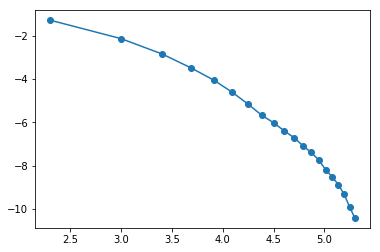

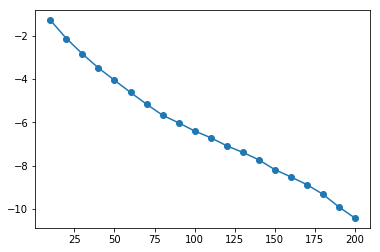

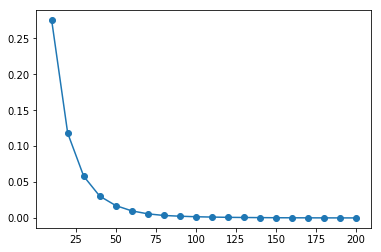

In [74]:
x = np.array(range(10,201,10))
# log-log plot of residual
plt.plot(np.log(x), np.log(residual), marker='o')
plt.show()
# log plot of residual
plt.plot(x, np.log(residual), marker='o')
plt.show()
# plot of residual
plt.plot(x, residual, marker='o')
plt.show()

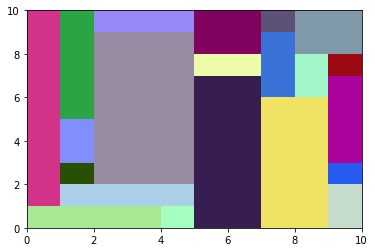

In [75]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
rect_lst = m.rect_on_map_list()
shape = m.shape
#print rect_lst
fig, ax = plt.subplots(1)
# Create a Rectangle patch
plt.xlim((0, shape[0]))
plt.ylim((0, shape[1]))

n = len(rect_lst)
for i, rect in enumerate(rect_lst):
    xmin,xmax,ymin,ymax = rect.get_position()
    corner = [xmin, ymin]
    h = xmax-xmin+1
    w = ymax-ymin+1
    c = [(n-i)*1.0/n, (n-i)*1.0/n, i*1.0/n]
    c = list(np.random.choice(range(256), size=3)/255.0)
    ax.add_patch(patches.Rectangle(corner, h, w, facecolor=c))
    
plt.show()
